In [1]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pandas as pd
import glob
import cv2
import random as rand

from scipy.spatial import distance

import cv2

import matplotlib.pyplot as plt

import os
import xml.etree.ElementTree as et
import re
import pandas as pd

In [2]:
dic = {"image": [],"Dimensions": []}
for i in range(1,116):
	dic[f'Object {i}']=[]
print("Generating data in CSV format....")

for file in os.listdir("/kaggle/input/face-mask-detection/annotations"):
    row = []
    xml = et.parse("/kaggle/input/face-mask-detection/annotations/"+file) 
    root = xml.getroot()
    img = root[1].text
    row.append(img)
    h,w = root[2][0].text,root[2][1].text
    row.append([h,w])

    for i in range(4,len(root)):
        temp = []
        temp.append(root[i][0].text)
        for point in root[i][5]:
            temp.append(point.text)
        row.append(temp)
    for i in range(len(row),119):
        row.append(0)
    for i,each in enumerate(dic):
        dic[each].append(row[i])
df = pd.DataFrame(dic)

df.head()

Generating data in CSV format....


,image,Dimensions,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,Object 8,...,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,maksssksksss737.png,"[400, 226]","[with_mask, 28, 55, 46, 71]","[with_mask, 98, 62, 111, 78]","[mask_weared_incorrect, 159, 50, 193, 90]","[with_mask, 293, 59, 313, 80]","[with_mask, 352, 51, 372, 72]","[with_mask, 228, 53, 241, 73]",0,0,...,0,0,0,0,0,0,0,0,0,0
1,maksssksksss410.png,"[400, 267]","[with_mask, 34, 153, 62, 176]","[with_mask, 88, 138, 111, 163]","[with_mask, 139, 207, 168, 234]","[with_mask, 116, 135, 135, 154]","[with_mask, 135, 103, 152, 121]","[mask_weared_incorrect, 101, 91, 115, 106]","[with_mask, 58, 109, 72, 127]","[with_mask, 56, 91, 65, 103]",...,0,0,0,0,0,0,0,0,0,0
2,maksssksksss537.png,"[301, 400]","[without_mask, 95, 177, 195, 295]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,maksssksksss295.png,"[267, 400]","[with_mask, 92, 76, 168, 162]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,maksssksksss771.png,"[400, 267]","[with_mask, 31, 109, 93, 161]","[with_mask, 83, 43, 119, 86]","[with_mask, 140, 70, 195, 128]","[with_mask, 280, 77, 366, 165]","[with_mask, 360, 10, 394, 46]",0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
image_directories = sorted(glob.glob(os.path.join("/kaggle/input/face-mask-detection/images","*.png")))
j=0
classes = ["without_mask","mask_weared_incorrect","with_mask"]
labels = []
data = []

print("Extracting each data into respective label folders....")
for idx,image in enumerate(image_directories):
    img  = cv2.imread(image)
    #scale to dimension
    X,Y = df["Dimensions"][idx]
    cv2.resize(img,(int(X),int(Y)))
    #find the face in each object
    for obj in df.columns[3:]:
        info = df[obj][idx]
        if info!=0:
            label = info[0]
            info[0] = info[0].replace(str(label), str(classes.index(label)))
            info=[int(each) for each in info]
            face = img[info[2]:info[4],info[1]:info[3]]
            if((info[3]-info[1])>40 and (info[4]-info[2])>40):
                try:
                    face = cv2.resize(face, (256, 256))
                    face = img_to_array(face)
                    face = preprocess_input(face)
                    data.append(face)
                    labels.append(label)
                    if(label=="mask_weared_incorrect"):
                        data.append(face)
                        labels.append(label)

                except:
                    pass


                
print("Done!")

Extracting each data into respective label folders....
Done!


In [4]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
labels

array(['with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'mask_weared_incorrect', 'mask_weared_incorrect',
       'with_mask', 'without_mask', 'with_mask', 'without_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'without_mask', 'with_mask',
       'without_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'without_mask', 'with

In [5]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [7]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(256, 256, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [8]:
INIT_LR = 1e-4
EPOCHS = 100
BS = 1

In [9]:
len(data)

334

In [10]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.3, stratify=labels, shuffle=True)

In [11]:
print("[INFO] compiling model...")
opt = tf.keras.optimizers.legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
233/233 [==============================] - 18s 62ms/step - loss: 0.8028 - accuracy: 0.7511 - val_loss: 0.6104 - val_accuracy: 0.8218
Epoch 2/100
233/233 [==============================] - 15s 64ms/step - loss: 0.6387 - accuracy: 0.8112 - val_loss: 0.6084 - val_accuracy: 0.8218
Epoch 3/100
233/233 [==============================] - 15s 64ms/step - loss: 0.6437 - accuracy: 0.8026 - val_loss: 0.5890 - val_accuracy: 0.8218
Epoch 4/100
233/233 [==============================] - 15s 63ms/step - loss: 0.6224 - accuracy: 0.8197 - val_loss: 0.5911 - val_accuracy: 0.8218
Epoch 5/100
233/233 [==============================] - 13s 54ms/step - loss: 0.6259 - accuracy: 0.8240 - val_loss: 0.6311 - val_accuracy: 0.8218
Epoch 6/100
233/233 [==============================] - 13s 56ms/step - loss: 0.5742 - accuracy: 0.8283 - val_loss: 0.6172 - val_accuracy: 0.8218
Epoch 7/100
233/233 [==============================] - 13s 54ms/step - loss: 0.5146 - accuracy: 0.8155 - val_loss: 0.6275 - val_ac

[INFO] evaluating network...
4/4 [==============================] - 5s 868ms/step
                       precision    recall  f1-score   support

mask_weared_incorrect       0.60      0.43      0.50         7
            with_mask       0.84      0.93      0.88        83
         without_mask       0.00      0.00      0.00        11

             accuracy                           0.79       101
            macro avg       0.48      0.45      0.46       101
         weighted avg       0.73      0.79      0.76       101

[INFO] saving mask detector model...


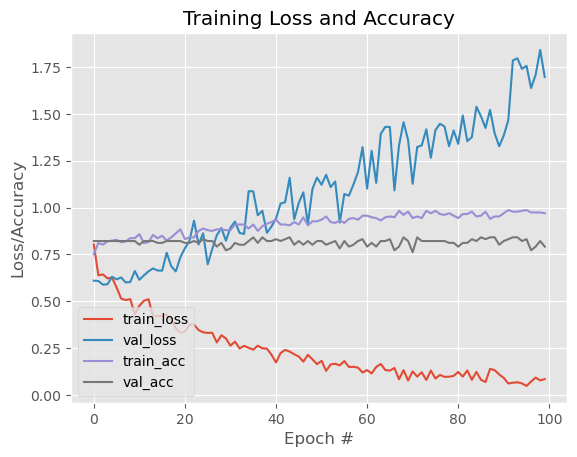

In [12]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

# Another method

In [13]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')

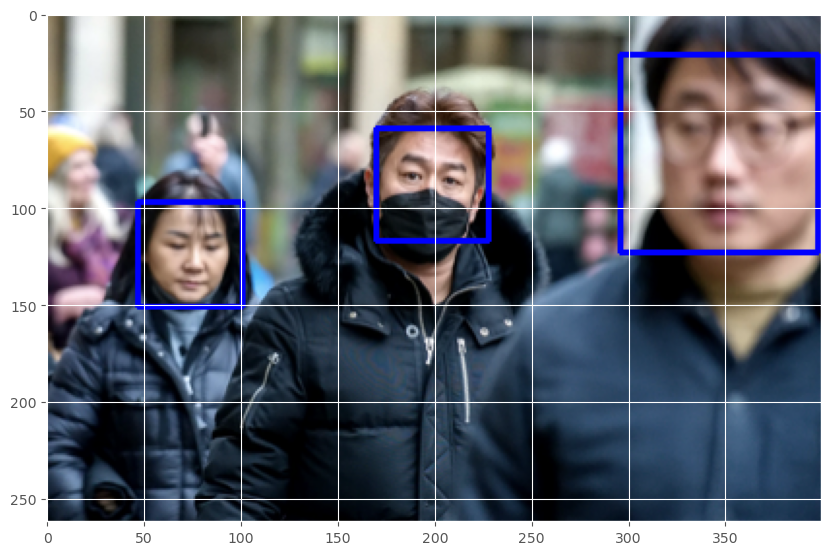

In [15]:
#trying it out on a sample image
img = cv2.imread('../input/face-mask-detection/images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),2)
plt.figure(figsize=(10,10))
plt.imshow(out_img)

In [16]:
MIN_DISTANCE = 130

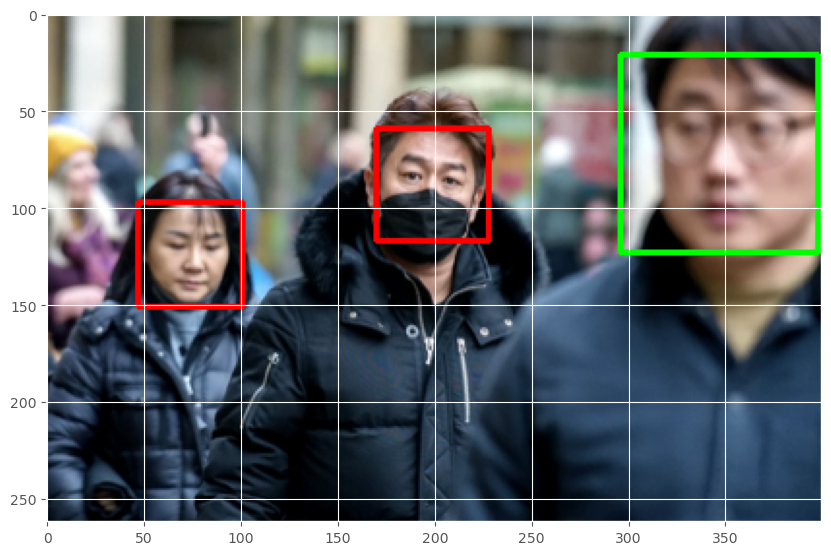

In [17]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),2)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

In [18]:
#augmentation
train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(256,256),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(256,256),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(256,256),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [19]:
mobilenet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(256,256,3))
for layer in mobilenet.layers:
    layer.trainable = False
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense_3 (Dense)             (None, 16)                1310736   
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,568,754
Trainable params: 1,310,770
Non-trainable params: 2,257,984
______________________________________

In [20]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")
history = model.fit_generator(verbose=2,generator=train_generator,steps_per_epoch=len(train_generator)//32,epochs=100,validation_data=val_generator,validation_steps=len(val_generator)//32)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
9/9 - 17s - loss: 0.5020 - accuracy: 0.8611 - 17s/epoch - 2s/step
Epoch 2/100
9/9 - 13s - loss: 0.1795 - accuracy: 0.9583 - 13s/epoch - 1s/step
Epoch 3/100
9/9 - 13s - loss: 0.2199 - accuracy: 0.9306 - 13s/epoch - 1s/step
Epoch 4/100
9/9 - 12s - loss: 0.0722 - accuracy: 0.9549 - 12s/epoch - 1s/step
Epoch 5/100
9/9 - 13s - loss: 0.0630 - accuracy: 0.9757 - 13s/epoch - 1s/step
Epoch 6/100
9/9 - 12s - loss: 0.0444 - accuracy: 0.9757 - 12s/epoch - 1s/step
Epoch 7/100
9/9 - 13s - loss: 0.0578 - accuracy: 0.9757 - 13s/epoch - 1s/step
Epoch 8/100
9/9 - 13s - loss: 0.0484 - accuracy: 0.9826 - 13s/epoch - 1s/step
Epoch 9/100
9/9 - 13s - loss: 0.1090 - accuracy: 0.9583 - 13s/epoch - 1s/step
Epoch 10/100
9/9 - 12s - loss: 0.0940 - accuracy: 0.9596 - 12s/epoch - 1s/step
Epoch 11/100
9/9 - 13s - loss: 0.0796 - accuracy: 0.9722 - 13s/epoch - 1s/step
Epoch 12/100
9/9 - 12s - loss: 0.0804 - accuracy: 0.9743 - 12s/epoch - 1s/step
Epoch 13/100
9/9 - 12s - loss: 0.0399 - accuracy: 0.9826 - 12

In [21]:
model.evaluate_generator(test_generator)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.006238232832401991, 0.9975000023841858]

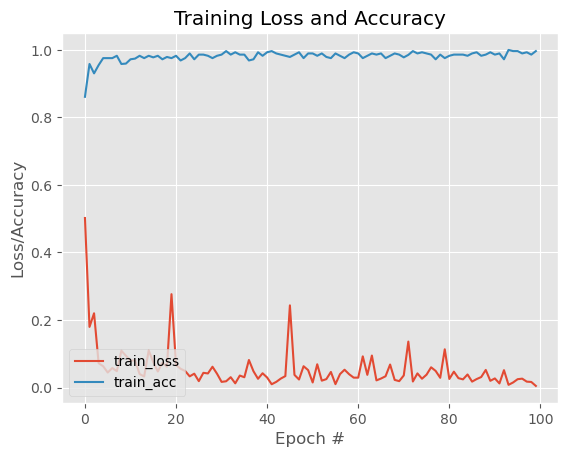

In [22]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

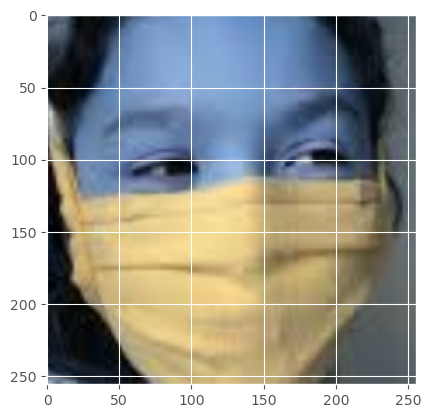

In [23]:
sample_mask_img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img,(256,256))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
sample_mask_img = sample_mask_img/255.0

In [24]:
model.predict(sample_mask_img)

1/1 [==============================] - 1s 972ms/step


array([[2.3357393e-03, 6.2128612e-16]], dtype=float32)

In [25]:
model.save('masknet.h5')

In [26]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

1/1 [==============================] - 0s 51ms/step


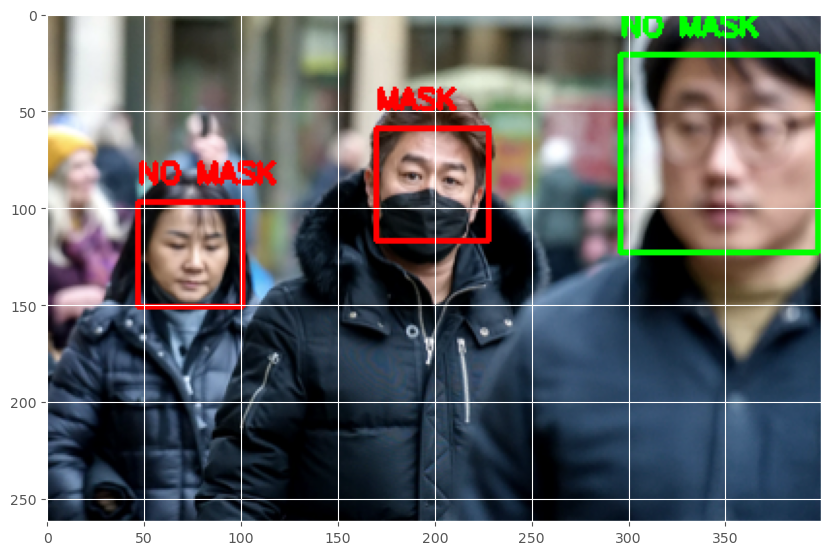

In [27]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(256,256))
        crop = np.reshape(crop,[1,256,256,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")